In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import itertools
import datetime
import warnings
warnings.filterwarnings("ignore")


In [2]:
path = r"data\orbital_elements\Fengyun-2F.csv"

df = pd.read_csv(path, index_col=0, parse_dates=True)

In [3]:
df

,eccentricity,argument of perigee,inclination,mean anomaly,Brouwer mean motion,right ascension
2012-09-06 18:48:32.050655,0.000488,4.483911,0.032940,-2.689729,0.004374,4.842139
2012-09-07 19:39:45.383327,0.000487,4.481215,0.032901,-2.446726,0.004374,4.842234
2012-09-08 15:43:39.075167,0.000487,4.475122,0.032868,-3.457326,0.004374,4.842332
2012-09-09 12:53:36.595967,0.000492,4.481063,0.032835,-4.190783,0.004374,4.842201
2012-09-10 13:15:22.135391,0.000495,4.512943,0.032798,-4.111348,0.004374,4.842257
...,...,...,...,...,...,...
2021-12-25 04:39:15.108767,0.000330,0.082144,0.058788,-2.965046,0.004375,1.413225
2021-12-28 21:00:18.080928,0.000355,0.140658,0.058901,-4.964060,0.004375,1.412455
2022-01-06 13:25:24.541247,0.000527,6.211157,0.059350,-0.307468,0.004376,1.411825
2022-01-07 18:42:19.086048,0.000533,6.231944,0.059406,-5.206757,0.004376,1.411793


In [4]:
df.index.inferred_type

'datetime64'

In [5]:
print(df.isnull().sum())

eccentricity           0
argument of perigee    0
inclination            0
mean anomaly           0
Brouwer mean motion    0
right ascension        0
dtype: int64


In [6]:
duplicates = df.index.duplicated().sum()
duplicates

0

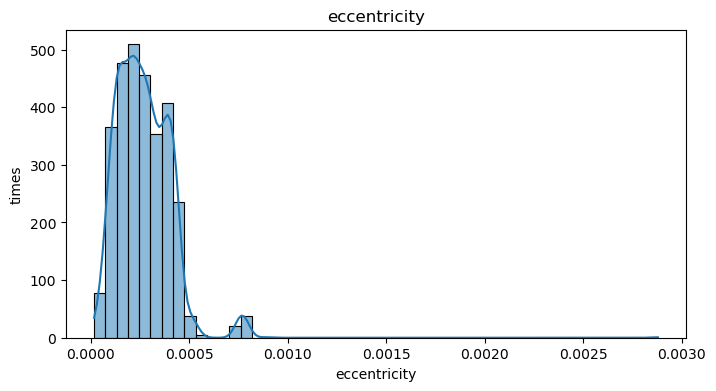

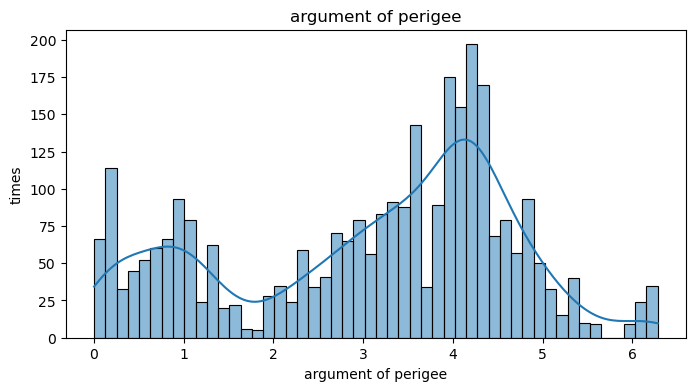

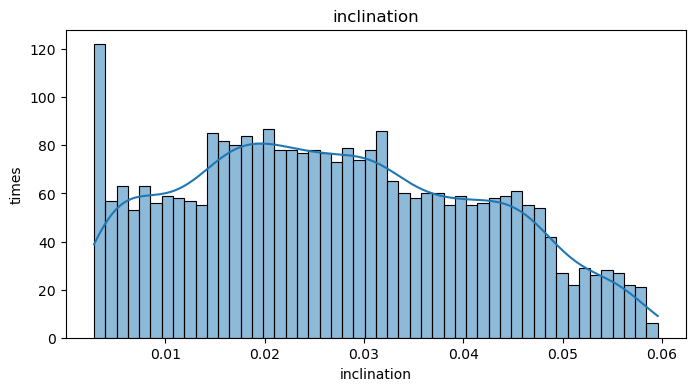

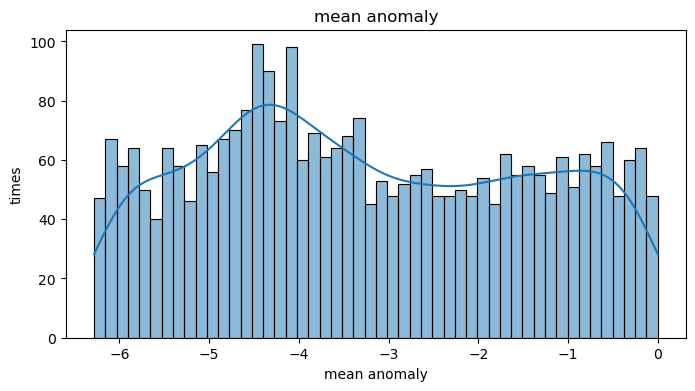

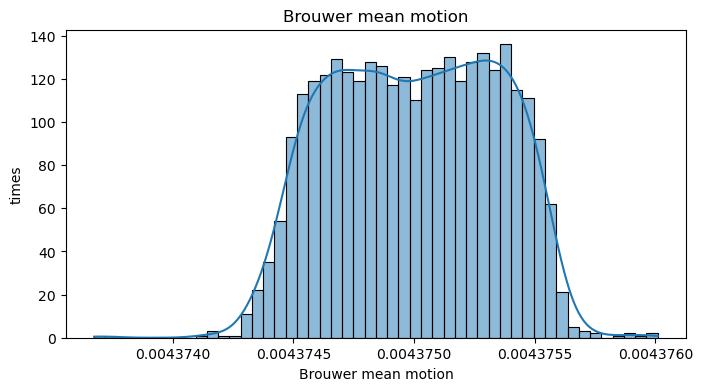

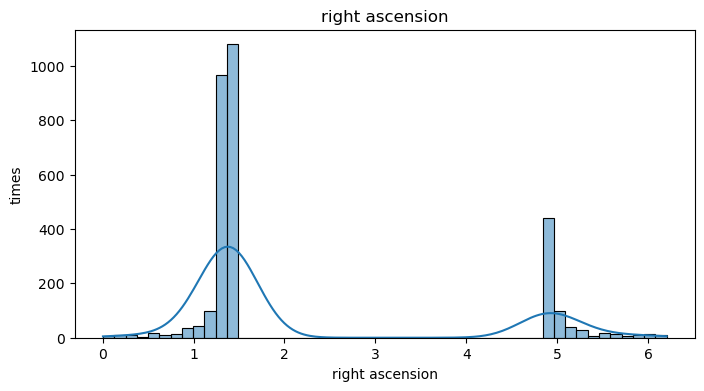

In [7]:
features = df.columns
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[feature], bins=50, kde=True)
    plt.title(f"{feature}")
    plt.xlabel(feature)
    plt.ylabel("times")
    plt.show()

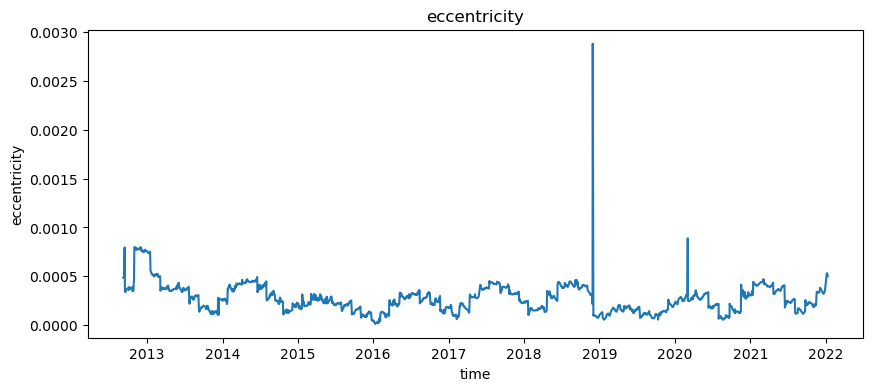

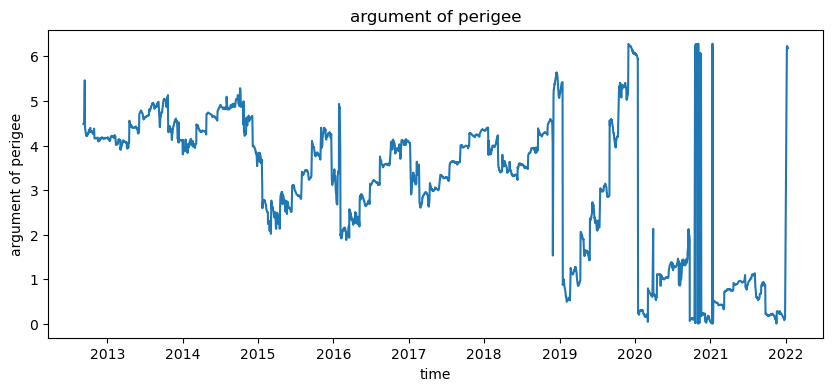

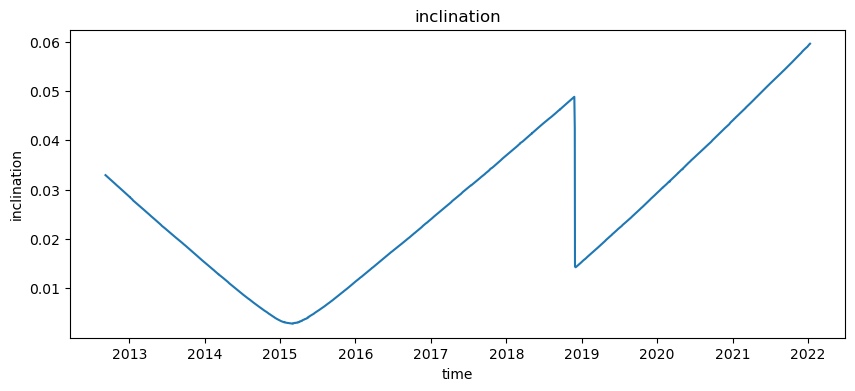

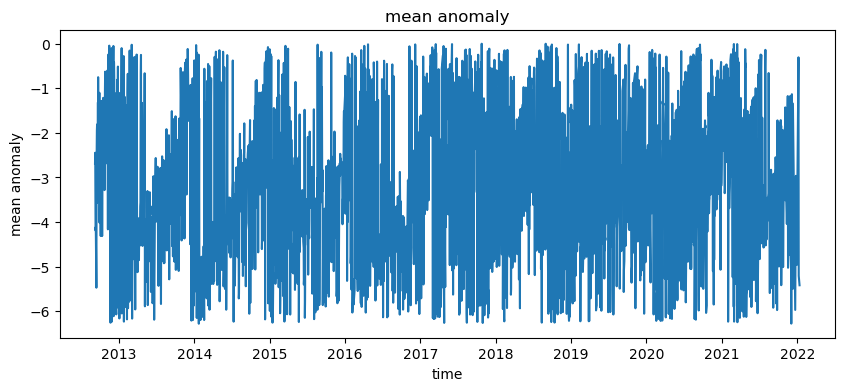

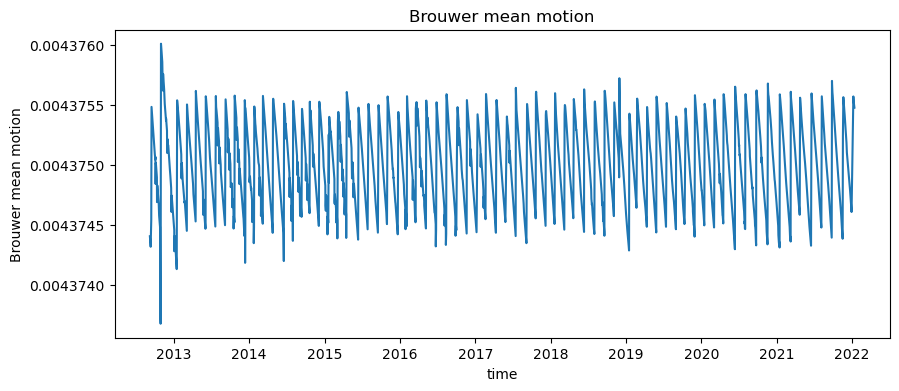

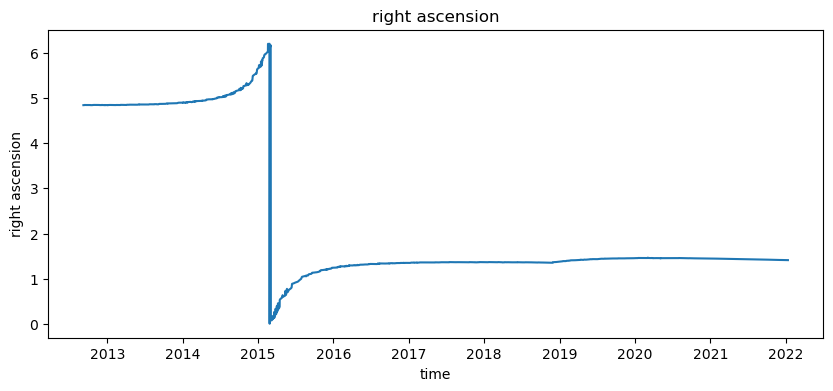

In [8]:
for feature in features:
    plt.figure(figsize=(10, 4))
    plt.plot(df.index, df[feature])
    plt.title(f"{feature}")
    plt.xlabel("time")
    plt.ylabel(feature)
    plt.show()

In [9]:
z_scores = np.abs(stats.zscore(df))

In [10]:
z_scores_df = pd.DataFrame(z_scores, index=df.index, columns=features)
z_scores_df.head()

,eccentricity,argument of perigee,inclination,mean anomaly,Brouwer mean motion,right ascension
2012-09-06 18:48:32.050655,1.565437,0.889018,0.409463,0.303823,1.767483,1.694235
2012-09-07 19:39:45.383327,1.556906,0.887309,0.406810,0.440163,1.837111,1.694296
2012-09-08 15:43:39.075167,1.555484,0.883448,0.404519,0.126849,1.894725,1.694359
2012-09-09 12:53:36.595967,1.591031,0.887213,0.402228,0.538366,1.956990,1.694275
2012-09-10 13:15:22.135391,1.613070,0.907413,0.399695,0.493797,2.025842,1.694311


In [11]:
threshold = 2
outliers = (z_scores_df > threshold)
outliers.sum()

eccentricity           61
argument of perigee    22
inclination            54
mean anomaly            0
Brouwer mean motion    30
right ascension        82
dtype: int64

In [12]:
obs = df["right ascension"]
obs = (obs - obs.mean())*1e-1
obs

2012-09-06 18:48:32.050655    0.265446
2012-09-07 19:39:45.383327    0.265456
2012-09-08 15:43:39.075167    0.265466
2012-09-09 12:53:36.595967    0.265452
2012-09-10 13:15:22.135391    0.265458
                                ...   
2021-12-25 04:39:15.108767   -0.077445
2021-12-28 21:00:18.080928   -0.077522
2022-01-06 13:25:24.541247   -0.077585
2022-01-07 18:42:19.086048   -0.077588
2022-01-11 17:26:36.259583   -0.077639
Name: right ascension, Length: 2985, dtype: float64

In [13]:
obs.describe()

count    2985.000000
mean        0.000000
std         0.156702
min        -0.218391
25%        -0.082772
50%        -0.076358
75%        -0.073010
max         0.401409
Name: right ascension, dtype: float64

In [14]:
# Split data: 60% training, 20% validation, 20% test
train_size = int(len(obs) * 0.6)
val_size = int(len(obs) * 0.2)

train_data = obs.iloc[:train_size]
val_data = obs.iloc[train_size:train_size + val_size]
test_data = obs.iloc[train_size + val_size:]

# ARIMA

In [15]:
# Combine training and validation data for model tuning
tuning_data = pd.concat([train_data, val_data])
print("Length of tuning data:", len(tuning_data))
print("Length of test data:", len(test_data))

Length of tuning data: 2388
Length of test data: 597


### Exploratory Data Analysis on Tuning Data

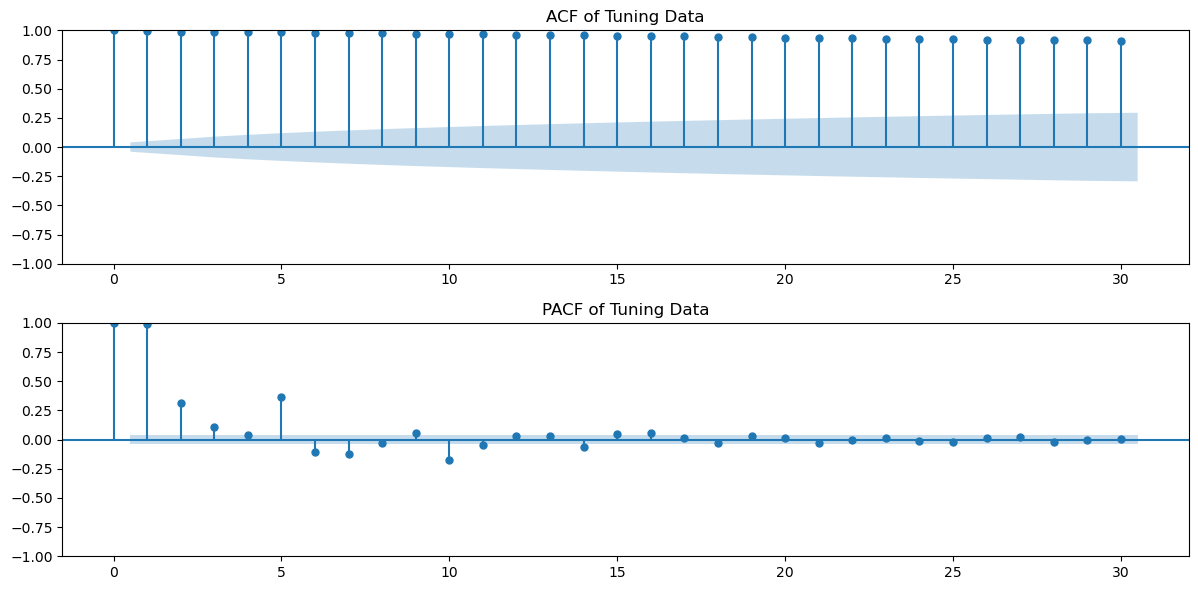

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(tuning_data, lags=30, ax=plt.gca(), title='ACF of Tuning Data')
plt.subplot(2, 1, 2)
plot_pacf(tuning_data, lags=30, ax=plt.gca(), title='PACF of Tuning Data')
plt.tight_layout()
plt.show()

In [17]:
# Perform ADF test to check stationarity
adf_result = adfuller(tuning_data)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Number of lags used:", adf_result[2])
print("Number of observations used:", adf_result[3])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.3f}")

ADF Statistic: -1.9600698496924265
p-value: 0.30435070108649276
Number of lags used: 20
Number of observations used: 2367
Critical Values:
   1%: -3.433
   5%: -2.863
   10%: -2.567


### Differencing Until Stationary

In [18]:
stationary_data = tuning_data.copy()
diff = 0
while True:
    result = adfuller(stationary_data)
    if result[1] < 0.05:
        break
    stationary_data = stationary_data.diff().dropna()
    diff += 1
print(f"Tuning data was differenced {diff} times to achieve stationarity.")

Tuning data was differenced 1 times to achieve stationarity.


### ARIMA Parameter Tuning on Tuning Data using AIC

In [19]:
p_range = range(0, 6)
d_range = range(0, 2)  
q_range = range(0, 6)

Best ARIMA parameters: (p, d, q) = (0, 1, 5), with AIC = -12462.19


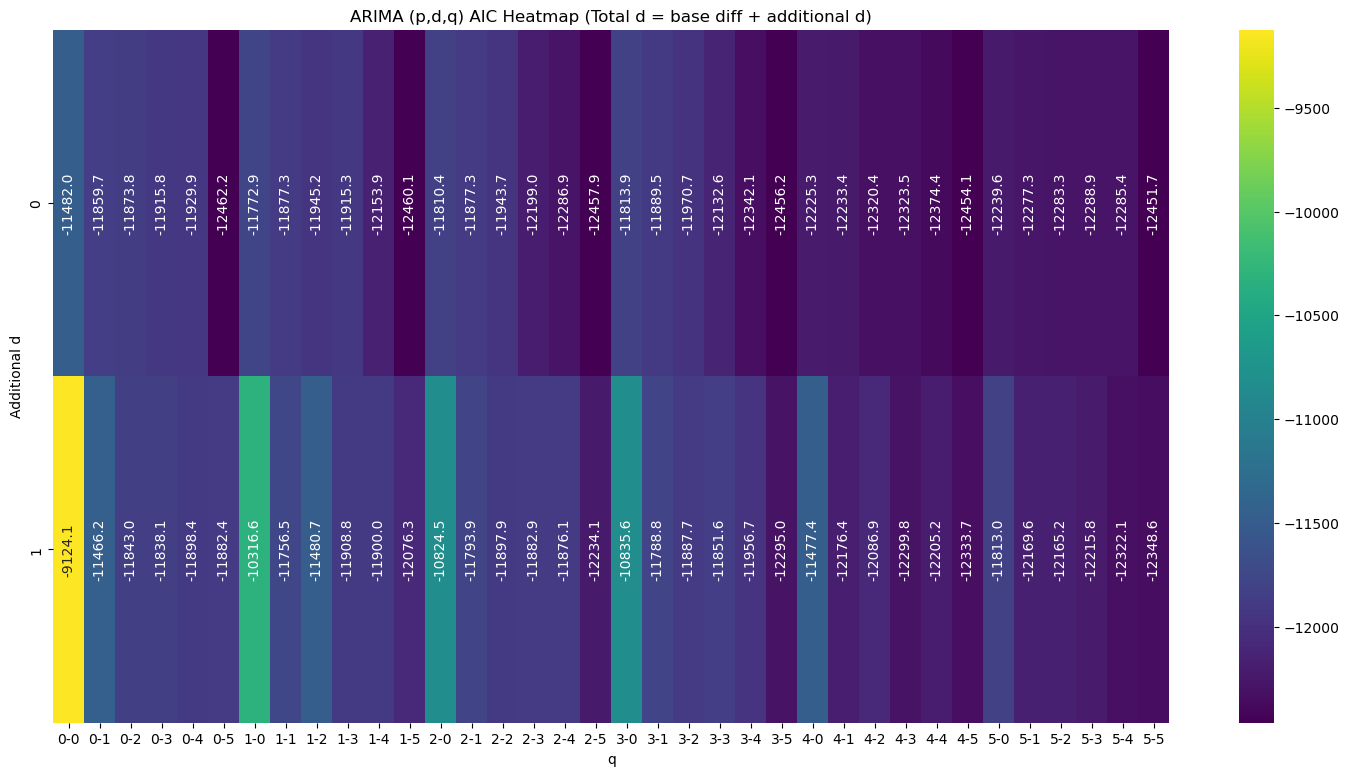

In [20]:
results = []
for p, d, q in itertools.product(p_range, d_range, q_range):
    try:
        order = (p, diff + d, q)
        model = ARIMA(tuning_data, order=order).fit()
        results.append((p, d, q, model.aic))
    except Exception as e:
        continue

best_model = min(results, key=lambda x: x[3])
best_p, best_d, best_q, best_aic = best_model
total_d = diff + best_d
print(f"Best ARIMA parameters: (p, d, q) = ({best_p}, {total_d}, {best_q}), with AIC = {best_aic:.2f}")

# Plot grid search heatmap (using additional d as the row index)
results_df = pd.DataFrame(results, columns=['p', 'd', 'q', 'aic'])
heatmap_table = pd.pivot_table(results_df, index='d', columns=['p', 'q'], values='aic', aggfunc=min)
plt.figure(figsize=(18, 9))
sns.heatmap(heatmap_table, cmap='viridis', annot=True, fmt='.1f', annot_kws={'rotation': 90})
plt.xlabel('q')
plt.ylabel('Additional d')
plt.title('ARIMA (p,d,q) AIC Heatmap (Total d = base diff + additional d)')
plt.show()

In [21]:
best_order_total = (best_p, total_d, best_q)

In [22]:
# According to Option 2 on 16th Apr discussion, after hyperparameter tuning (using train+val),
# we retrain the final ARIMA model on 100% of the data (i.e., train, val, and test).
final_data = obs.copy()  # 100% of the data

### In-Sample Forecast using predict(dynamic=False)

In [23]:
# Fit ARIMA on the entire data 
model_final = ARIMA(final_data, order=best_order_total).fit()

# In-sample prediction (dynamic=False uses actual historical data for each prediction)
predictions_full = model_final.predict(start=final_data.index[1], end=final_data.index[-1], dynamic=False)

# Calculate in-sample residuals
residuals_full = final_data.iloc[1:] - predictions_full

mae_full = mean_absolute_error(final_data.iloc[1:], predictions_full)

print("In-sample MAE for ARIMA model:", mae_full)

In-sample MAE for ARIMA model: 0.001161138590131373


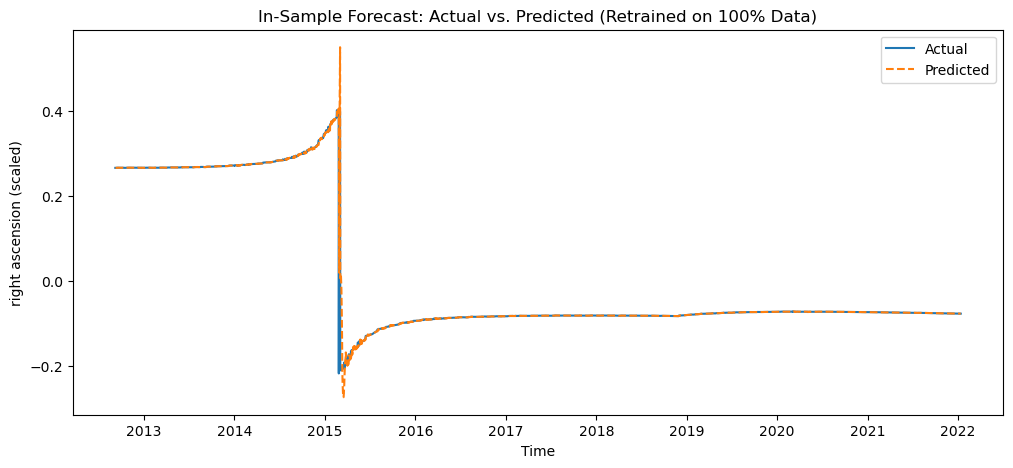

In [24]:
# Plot actual vs. predicted
plt.figure(figsize=(12, 5))
plt.plot(final_data.index, final_data, label="Actual")
plt.plot(predictions_full.index, predictions_full, label="Predicted", linestyle="--")
plt.xlabel("Time")
plt.ylabel("right ascension (scaled)")
plt.title("In-Sample Forecast: Actual vs. Predicted (Retrained on 100% Data)")
plt.legend()
plt.show()

<Figure size 800x600 with 0 Axes>

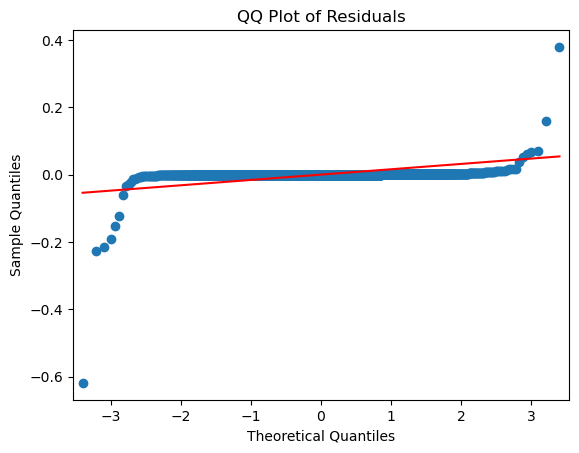

In [25]:
# Plot QQ plot for residuals to check linearity
plt.figure(figsize=(8, 6))
qqplot(residuals_full, line='s')
plt.title("QQ Plot of Residuals")
plt.show()

### Anomaly Detection using Quantile-based Thresholds

Lower threshold (1st percentile): -0.0027254186344171684
Upper threshold (99th percentile): 0.005364281190720006


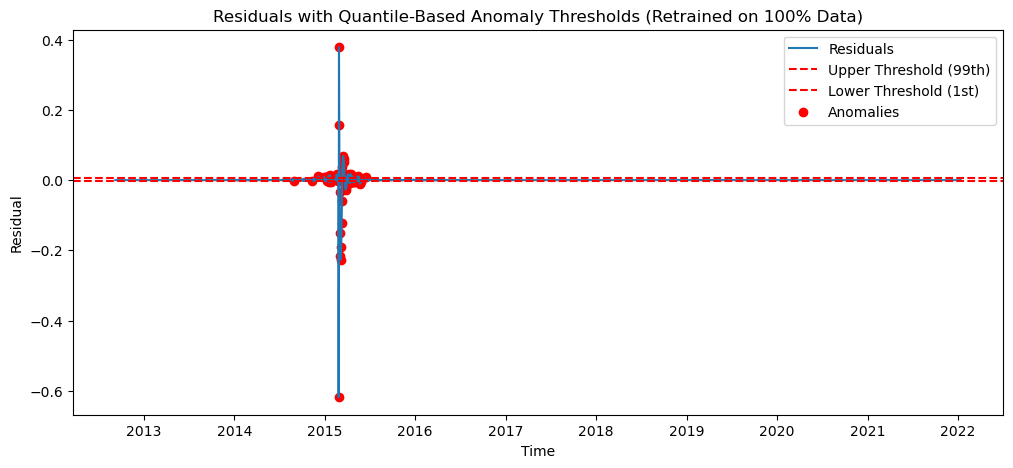

In [26]:
# Define thresholds using quantiles: lower threshold at 1st percentile, upper threshold at 99th percentile
lower_threshold = residuals_full.quantile(0.01)
upper_threshold = residuals_full.quantile(0.99)
print("Lower threshold (1st percentile):", lower_threshold)
print("Upper threshold (99th percentile):", upper_threshold)

# Identify anomalies where residuals fall outside these thresholds
anomalies = residuals_full[(residuals_full < lower_threshold) | (residuals_full > upper_threshold)]

# Plot the residuals, thresholds, and anomaly points
plt.figure(figsize=(12, 5))
plt.plot(residuals_full.index, residuals_full, label="Residuals")
plt.axhline(upper_threshold, color='red', linestyle='--', label="Upper Threshold (99th)")
plt.axhline(lower_threshold, color='red', linestyle='--', label="Lower Threshold (1st)")
plt.scatter(anomalies.index, anomalies, color='red', label="Anomalies")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.title("Residuals with Quantile-Based Anomaly Thresholds (Retrained on 100% Data)")
plt.legend()
plt.show()

In [27]:
anomalies

2014-08-28 22:31:27.447168   -0.002924
2014-11-11 22:37:14.318975   -0.003369
2014-12-06 15:12:45.971423    0.010658
2014-12-27 18:41:14.160767    0.009101
2015-01-08 20:36:57.180959   -0.003545
2015-01-15 07:28:51.436416    0.010883
2015-01-16 21:37:47.745120   -0.004979
2015-01-21 13:01:15.989088    0.014018
2015-01-23 22:14:48.244992    0.005832
2015-01-25 00:17:58.559711    0.006180
2015-01-27 11:29:58.401023   -0.004903
2015-02-18 06:51:05.808095    0.016456
2015-02-19 06:47:59.275680    0.007026
2015-02-22 20:32:13.147007    0.006554
2015-02-24 03:37:58.289375   -0.003094
2015-02-25 19:58:37.003872   -0.003408
2015-02-26 06:32:10.811040   -0.618637
2015-02-27 17:56:27.830111    0.378875
2015-02-28 20:51:28.727136    0.157650
2015-03-01 21:09:01.147391   -0.033905
2015-03-03 11:27:08.218944   -0.151409
2015-03-04 06:31:10.469279   -0.216239
2015-03-06 18:50:37.230432   -0.226449
2015-03-08 19:59:09.492864   -0.190073
2015-03-10 13:54:39.093696   -0.123048
2015-03-11 17:28:18.31871

In [28]:
len(anomalies)

60

# XGboost

### Data Preprocessing and Feature Engineering

In [29]:
NUM_LAG_FEATURES = 3

df_mm = df[["right ascension"]]
df_mm = (df_mm - df_mm.mean())*1e-1

In [30]:
df_y = df_mm.copy()

# Create lag features:
df_x = df_mm.shift(1)

df_x = df_x.rename(columns={"right ascension": "ecc_lag_1"})
for lag in range(2, NUM_LAG_FEATURES + 1):
    df_x[f"ecc_lag_{lag}"] = df_mm.shift(lag)

In [31]:
# Remove the first NUM_LAG_FEATURES rows with missing lag values
df_x = df_x.iloc[NUM_LAG_FEATURES:]
df_y = df_y.iloc[NUM_LAG_FEATURES:]

### Data Splitting

In [32]:
STR_SPLIT_DATE = "2021-01-01"
df_x_train = df_x[:STR_SPLIT_DATE]
df_x_test = df_x[STR_SPLIT_DATE:]
df_y_train = df_y[:STR_SPLIT_DATE]
df_y_test = df_y[STR_SPLIT_DATE:]

print("Training set length:", len(df_x_train))
print("Test set length:", len(df_x_test))

Training set length: 2651
Test set length: 332


### Hyperparameter Tuning on the Training Set

In [33]:
# Use GridSearchCV to select the best hyperparameters for XGBoost
param_grid = {
    'n_estimators': [10, 30, 50, 100, 200],
    'max_depth': [1, 2, 3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.5],
    'eval_metric': ['mae']
}

In [34]:
# Create initial XGBRegressor with early stopping rounds and a random state
xgb_regressor_object = XGBRegressor(
    early_stopping_rounds=10,
    random_state=42,
    verbosity=1
)

# Use GridSearchCV (10-fold CV) on the training data. Pass the eval_set for early stopping.
grid_search = GridSearchCV(
    estimator=xgb_regressor_object,
    param_grid=param_grid,
    cv=10,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV on the training set and use the training set itself as eval_set,
# plus optionally passing the temporary test set if desired.
grid_search.fit(
    df_x_train,
    df_y_train.values.ravel(),
    eval_set=[(df_x_train, df_y_train), (df_x_test, df_y_test)],
    verbose=True
)

print("Best hyperparameters from tuning:", grid_search.best_params_)
best_params = grid_search.best_params_

Fitting 10 folds for each of 150 candidates, totalling 1500 fits
[0]	validation_0-mae:0.07156	validation_1-mae:0.04050
[1]	validation_0-mae:0.03642	validation_1-mae:0.02101
[2]	validation_0-mae:0.01878	validation_1-mae:0.01085
[3]	validation_0-mae:0.00992	validation_1-mae:0.00602
[4]	validation_0-mae:0.00554	validation_1-mae:0.00344
[5]	validation_0-mae:0.00347	validation_1-mae:0.00192
[6]	validation_0-mae:0.00249	validation_1-mae:0.00119
[7]	validation_0-mae:0.00198	validation_1-mae:0.00087
[8]	validation_0-mae:0.00179	validation_1-mae:0.00067
[9]	validation_0-mae:0.00168	validation_1-mae:0.00063
Best hyperparameters from tuning: {'eval_metric': 'mae', 'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 10}


### Retrain Final Model on 100% of the Data (Option 2)

In [35]:
# According to Option 2, we retrain the final model using 100% of the available data.
df_x_all = df_x.copy()
df_y_all = df_y.copy()

In [36]:
final_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **best_params
)
final_model.fit(df_x_all, df_y_all.values.ravel())

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [37]:
# Retrieve and print feature importance scores (by "weight")
importance_scores = final_model.get_booster().get_score(importance_type="weight")
print("Feature importance scores:", importance_scores)

Feature importance scores: {'ecc_lag_1': 46.0, 'ecc_lag_2': 36.0, 'ecc_lag_3': 28.0}


### Forecast and Residual Calculation

In [38]:
# Generate predictions using the final model on the entire data
np_predictions = final_model.predict(df_x_all)
# Calculate residuals: actual minus predicted
np_residuals = df_y_all["right ascension"].to_numpy() - np_predictions

mae = mean_absolute_error(df_y_all, np_predictions)
print("XGBoost final model MAE:", mae)

XGBoost final model MAE: 0.0017191190485441516


In [39]:
# Create a DataFrame for plotting residuals
df_y_plotting = df_y_all.copy()
df_y_plotting["residuals"] = np_residuals

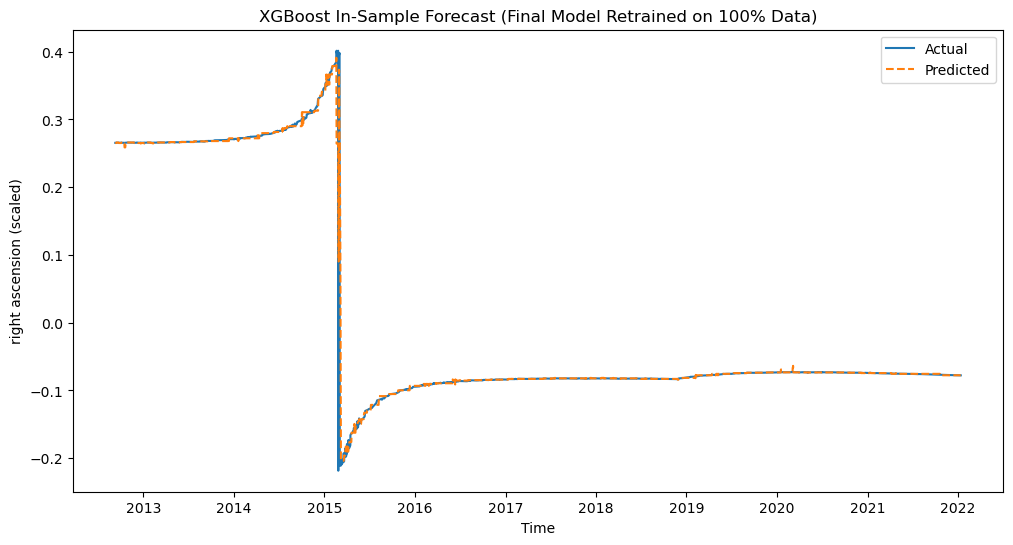

In [40]:
# Plot Actual vs. Predicted values
plt.figure(figsize=(12, 6))
plt.plot(df_y_all.index, df_y_all, label="Actual")
plt.plot(df_y_all.index, np_predictions, label="Predicted", linestyle="--")
plt.xlabel("Time")
plt.ylabel("right ascension (scaled)")
plt.title("XGBoost In-Sample Forecast (Final Model Retrained on 100% Data)")
plt.legend()
plt.show()

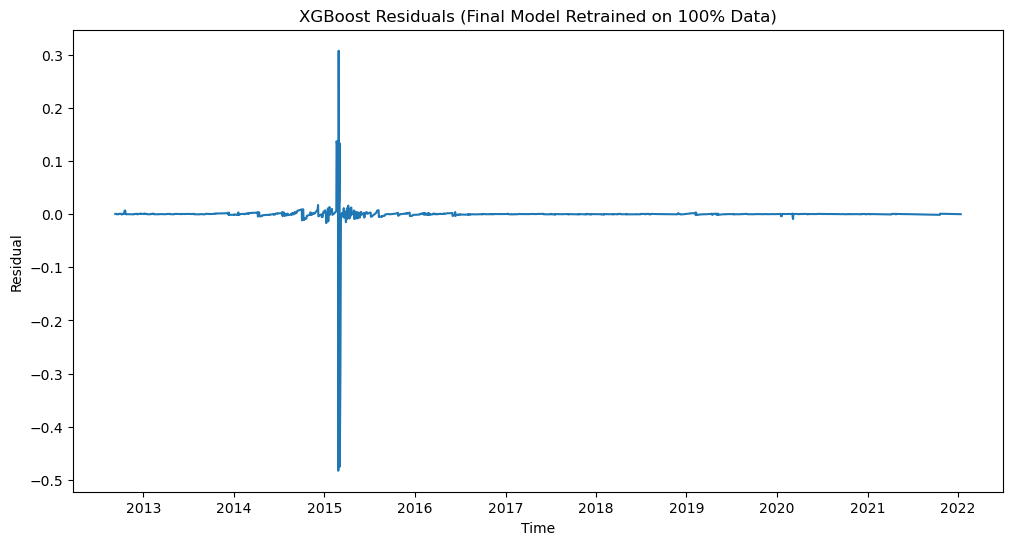

In [41]:
# Plot residuals using a seaborn lineplot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_y_plotting, x=df_y_plotting.index, y="residuals")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.title("XGBoost Residuals (Final Model Retrained on 100% Data)")
plt.show()

### Anomaly Detection Using Quantile-Based Thresholds

In [42]:
# Define quantile thresholds: lower (1st percentile) and upper (99th percentile)
lower_threshold = df_y_plotting["residuals"].quantile(0.01)
upper_threshold = df_y_plotting["residuals"].quantile(0.99)
print("Lower threshold (1st percentile):", lower_threshold)
print("Upper threshold (99th percentile):", upper_threshold)

Lower threshold (1st percentile): -0.006971479558642405
Upper threshold (99th percentile): 0.0079087284360759


In [43]:
# Identify anomalies: points where residuals are below the lower threshold or above the upper threshold
anomalies = df_y_plotting[(df_y_plotting["residuals"] < lower_threshold) | 
                          (df_y_plotting["residuals"] > upper_threshold)]

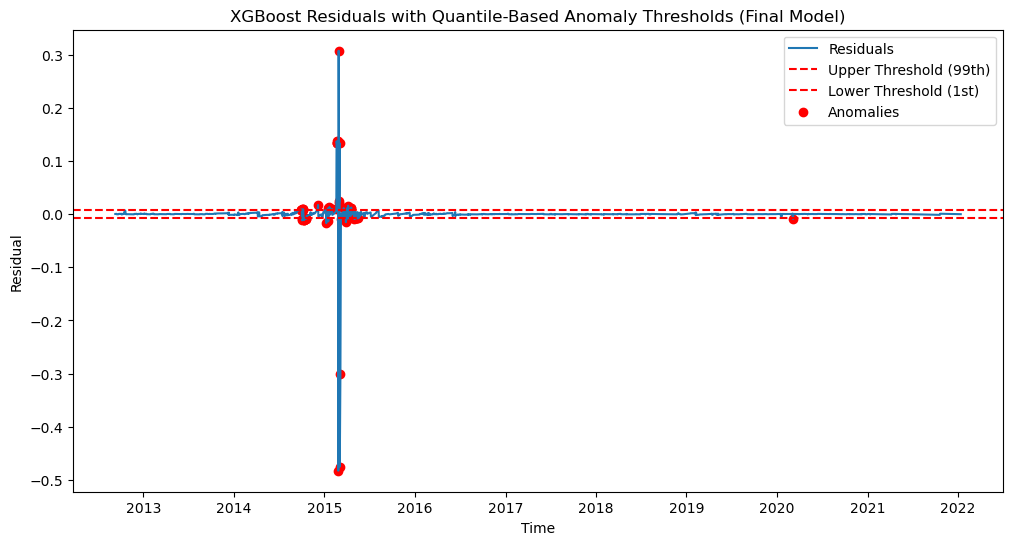

In [44]:
# Plot residuals with threshold lines and anomaly markers
plt.figure(figsize=(12, 6))
plt.plot(df_y_plotting.index, df_y_plotting["residuals"], label="Residuals")
plt.axhline(upper_threshold, color='red', linestyle="--", label="Upper Threshold (99th)")
plt.axhline(lower_threshold, color='red', linestyle="--", label="Lower Threshold (1st)")
plt.scatter(anomalies.index, anomalies["residuals"], color='red', label="Anomalies")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.title("XGBoost Residuals with Quantile-Based Anomaly Thresholds (Final Model)")
plt.legend()
plt.show()

In [45]:
anomalies

,right ascension,residuals
2014-09-28 00:10:45.937632,0.298298,0.008228
2014-09-29 08:25:23.772576,0.298489,0.008418
2014-09-30 13:54:27.126432,0.298722,0.008651
2014-10-01 21:00:26.045280,0.299048,0.008978
2014-10-02 11:26:49.540128,0.301620,-0.009066
2014-10-03 20:58:50.207808,0.298975,-0.011710
2014-10-05 19:58:54.512832,0.298332,0.008261
2014-10-06 20:44:47.078592,0.298825,0.008754
2014-10-07 22:08:41.672255,0.299059,0.008988
2014-10-08 22:01:43.110911,0.299466,-0.011220


In [46]:
len(anomalies)

60

# LSTM

### Data Preparation & Sequence Creation

In [47]:
WINDOW_SIZE = 5

# Assume df_tles is loaded with a DatetimeIndex and column "right ascension"
series = df[["right ascension"]].astype(float)
series_scaled = (series - series.mean())*1e-1

In [48]:
scaler = MinMaxScaler()
series_scaled["ecc_norm"] = scaler.fit_transform(series_scaled)

In [49]:
# Create supervised sequences
def create_sequences(data, window):
    X, y, idx = [], [], []
    arr = data["ecc_norm"].values
    timestamps = data.index
    for i in range(window, len(arr)):
        X.append(arr[i-window:i])
        y.append(arr[i])
        idx.append(timestamps[i])
    return np.array(X), np.array(y), pd.DatetimeIndex(idx)

In [50]:
X, y, seq_idx = create_sequences(series_scaled, WINDOW_SIZE)

# Reshape X to [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

### Train/Val/Test Split by Date

In [51]:
STR_SPLIT_DATE = "2021-01-01"
mask_trainval = seq_idx < STR_SPLIT_DATE
mask_test     = seq_idx >= STR_SPLIT_DATE

In [52]:
# Train+Val
X_tv, y_tv   = X[mask_trainval], y[mask_trainval]
idx_tv       = seq_idx[mask_trainval]
# Test
X_test, y_test, idx_test = X[mask_test], y[mask_test], seq_idx[mask_test]

In [53]:
# Further split train+val into train/val 80/20
split_val = int(len(X_tv) * 0.8)
X_tr, y_tr  = X_tv[:split_val], y_tv[:split_val]
X_val, y_val = X_tv[split_val:], y_tv[split_val:]
idx_val = idx_tv[split_val:]

print("Shapes → train:", X_tr.shape, "val:", X_val.shape, "test:", X_test.shape)

Shapes → train: (2118, 5, 1) val: (530, 5, 1) test: (332, 5, 1)


### LSTM Model Definition & Training on Train+Val

In [54]:
def build_lstm_model(units, lr, dropout_rate):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
    model.add(Dropout(dropout_rate/2))
    model.add(LSTM(units//2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model

In [55]:
# Manual hyperparameter setting
param_grid = {
    "units":       [20, 50, 100],
    "learning_rate":[0.001, 0.01],
    "batch_size":  [16],
    "dropout_rate":  [0.1, 0.3, 0.5]
}

best_mse = np.inf
best_params = None


Training with units=20, lr=0.001, bs=16, dr=0.1
 → val MSE=0.00000


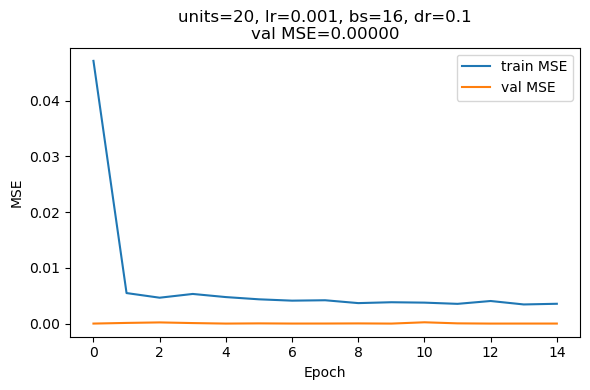


Training with units=20, lr=0.001, bs=16, dr=0.3
 → val MSE=0.00000


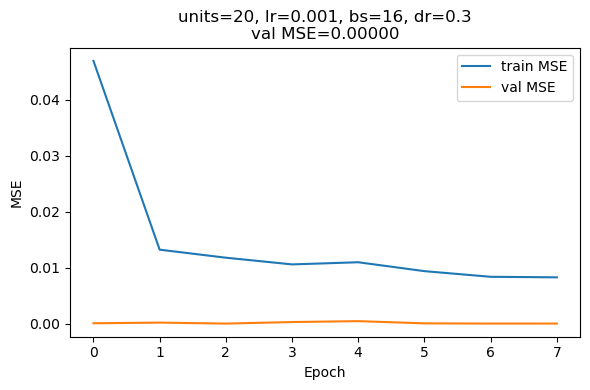


Training with units=20, lr=0.001, bs=16, dr=0.5
 → val MSE=0.00000


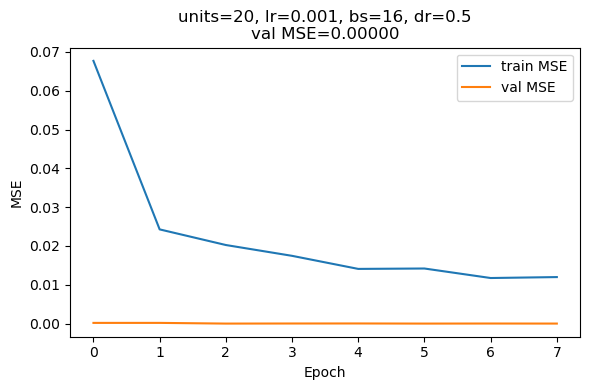


Training with units=20, lr=0.01, bs=16, dr=0.1
 → val MSE=0.00001


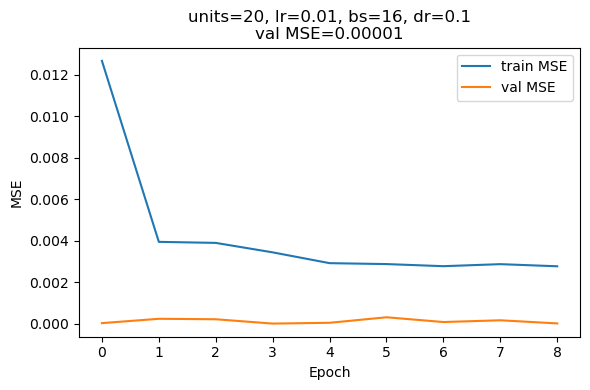


Training with units=20, lr=0.01, bs=16, dr=0.3
 → val MSE=0.00000


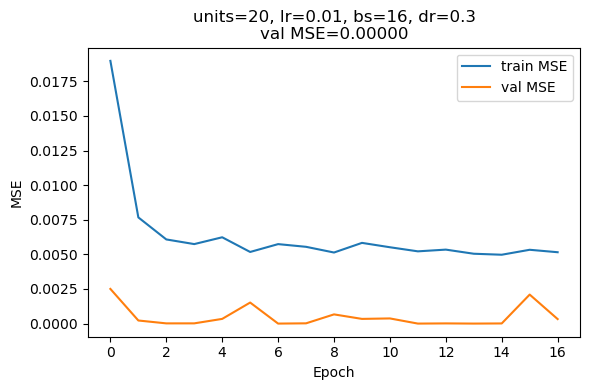


Training with units=20, lr=0.01, bs=16, dr=0.5
 → val MSE=0.00003


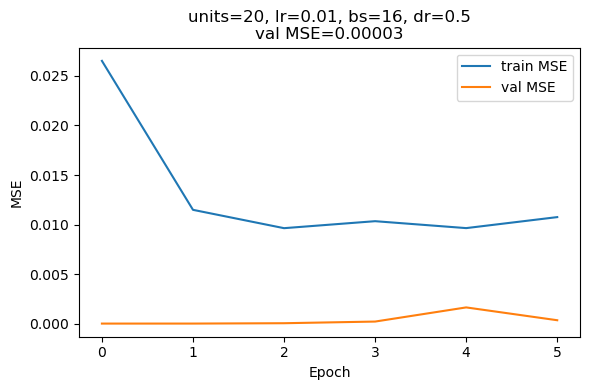


Training with units=50, lr=0.001, bs=16, dr=0.1
 → val MSE=0.00000


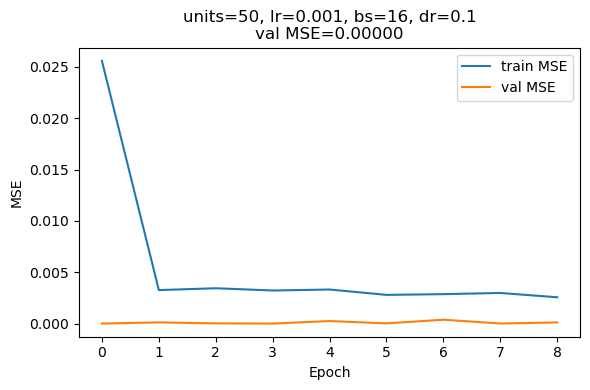


Training with units=50, lr=0.001, bs=16, dr=0.3
 → val MSE=0.00002


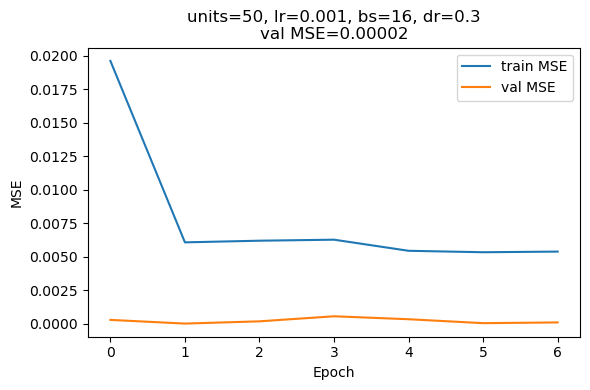


Training with units=50, lr=0.001, bs=16, dr=0.5
 → val MSE=0.00000


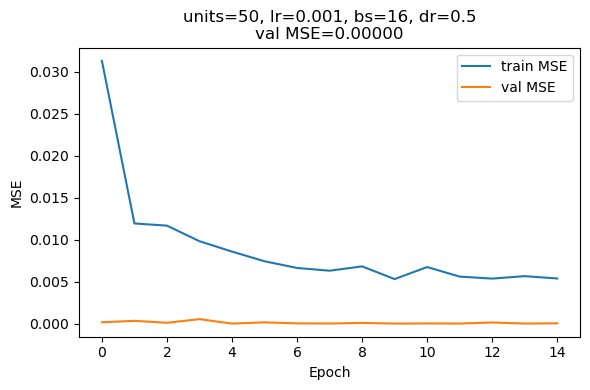


Training with units=50, lr=0.01, bs=16, dr=0.1
 → val MSE=0.00000


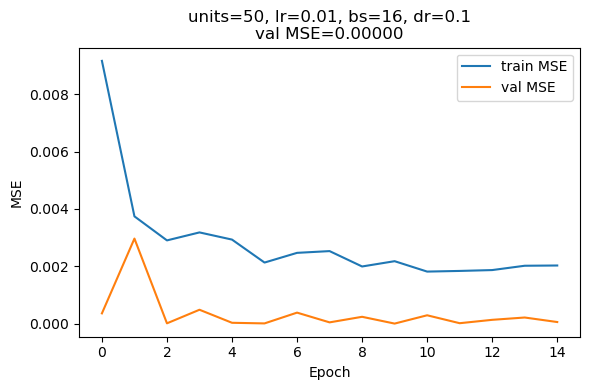


Training with units=50, lr=0.01, bs=16, dr=0.3
 → val MSE=0.00000


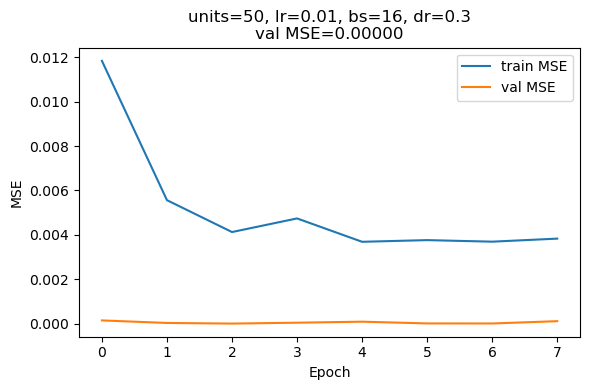


Training with units=50, lr=0.01, bs=16, dr=0.5
 → val MSE=0.00000


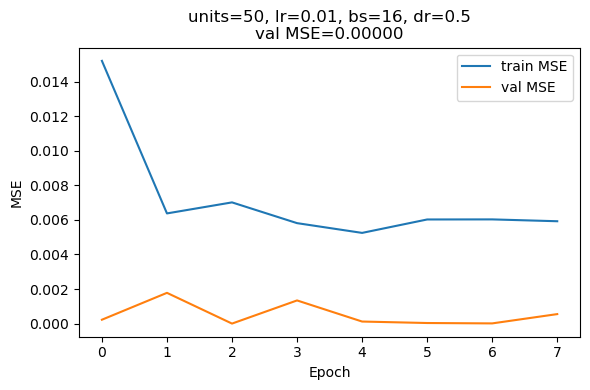


Training with units=100, lr=0.001, bs=16, dr=0.1
 → val MSE=0.00004


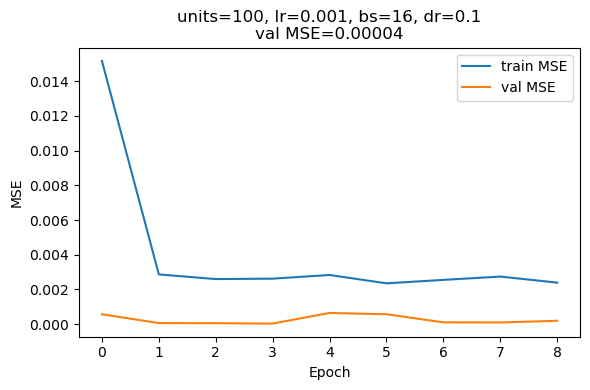


Training with units=100, lr=0.001, bs=16, dr=0.3
 → val MSE=0.00000


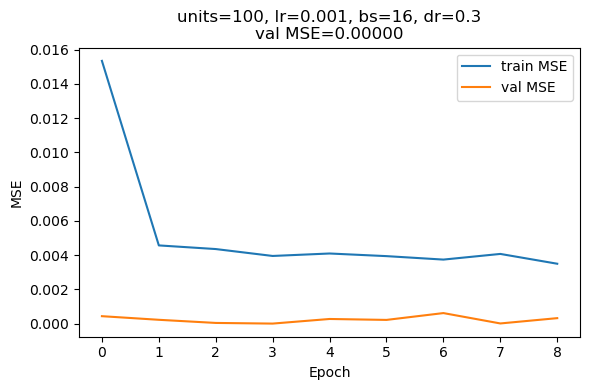


Training with units=100, lr=0.001, bs=16, dr=0.5
 → val MSE=0.00000


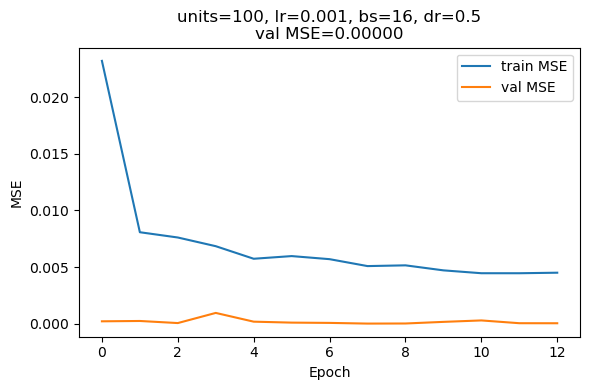


Training with units=100, lr=0.01, bs=16, dr=0.1
 → val MSE=0.00000


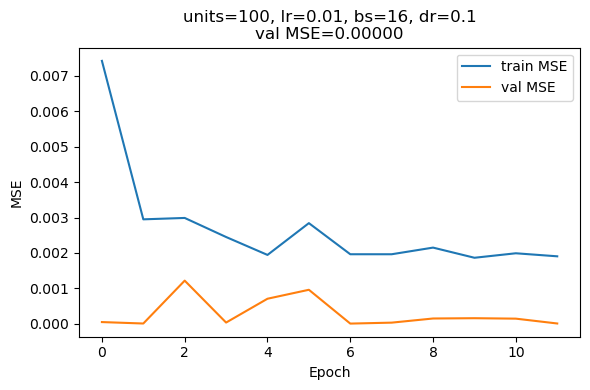


Training with units=100, lr=0.01, bs=16, dr=0.3
 → val MSE=0.00002


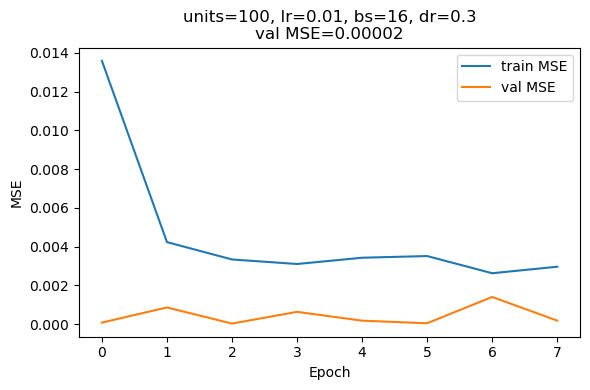


Training with units=100, lr=0.01, bs=16, dr=0.5
 → val MSE=0.00001


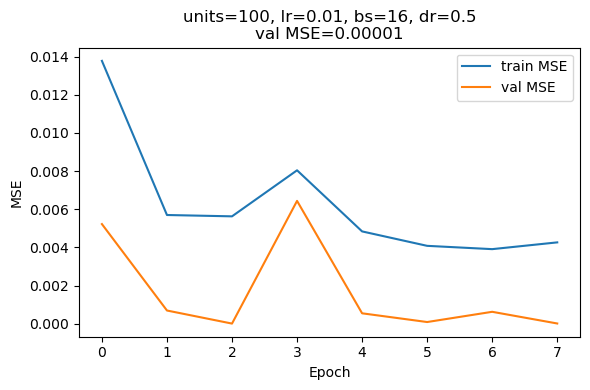


Best hyperparameters: {'units': 50, 'learning_rate': 0.01, 'batch_size': 16, 'dropout_rate': 0.5} with val MSE: 5.140052650176585e-08


In [56]:
for units in param_grid["units"]:
    for lr in param_grid["learning_rate"]:
        for bs in param_grid["batch_size"]:
            for dr in param_grid["dropout_rate"]:
                print(f"\nTraining with units={units}, lr={lr}, bs={bs}, dr={dr}")
                model = build_lstm_model(units, lr, dr)
                es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=0)
                history = model.fit(
                    X_tr, y_tr,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=bs,
                    callbacks=[es],
                    verbose=0
                )
                val_mse = min(history.history["val_loss"])
                print(f" → val MSE={val_mse:.5f}")

                # Plot train & val loss
                plt.figure(figsize=(6,4))
                plt.plot(history.history["loss"], label="train MSE")
                plt.plot(history.history["val_loss"], label="val MSE")
                plt.title(f"units={units}, lr={lr}, bs={bs}, dr={dr}\nval MSE={val_mse:.5f}")
                plt.xlabel("Epoch")
                plt.ylabel("MSE")
                plt.legend()
                plt.tight_layout()
                plt.show()

                if val_mse < best_mse:
                    best_mse = val_mse
                    best_params = {"units":units, "learning_rate":lr, "batch_size":bs, "dropout_rate":dr}

print("\nBest hyperparameters:", best_params, "with val MSE:", best_mse)

### Retrain Final Model on 100% of Data (Option 2)

In [57]:
# Combine train & val & test for final retraining
X_all = np.vstack([X_tv, X_test])
y_all = np.concatenate([y_tv, y_test])
idx_all = pd.DatetimeIndex(np.concatenate([idx_tv, idx_test]))

final_model = build_lstm_model(
    best_params["units"],
    best_params["learning_rate"],
    best_params["dropout_rate"]
)

es_final = EarlyStopping(monitor="loss", patience=5, restore_best_weights=True, verbose=0)
final_model.fit(
    X_all, y_all,
    epochs=50,
    batch_size=best_params["batch_size"],
    callbacks=[es_final],
    verbose=2
)

Epoch 1/50
187/187 - 1s - loss: 0.0115 - 1s/epoch - 8ms/step
Epoch 2/50
187/187 - 0s - loss: 0.0060 - 428ms/epoch - 2ms/step
Epoch 3/50
187/187 - 0s - loss: 0.0050 - 428ms/epoch - 2ms/step
Epoch 4/50
187/187 - 0s - loss: 0.0049 - 430ms/epoch - 2ms/step
Epoch 5/50
187/187 - 0s - loss: 0.0047 - 428ms/epoch - 2ms/step
Epoch 6/50
187/187 - 0s - loss: 0.0043 - 430ms/epoch - 2ms/step
Epoch 7/50
187/187 - 0s - loss: 0.0043 - 430ms/epoch - 2ms/step
Epoch 8/50
187/187 - 0s - loss: 0.0046 - 432ms/epoch - 2ms/step
Epoch 9/50
187/187 - 0s - loss: 0.0044 - 432ms/epoch - 2ms/step
Epoch 10/50
187/187 - 0s - loss: 0.0044 - 430ms/epoch - 2ms/step
Epoch 11/50
187/187 - 0s - loss: 0.0043 - 433ms/epoch - 2ms/step


### In‑Sample Forecast & Residuals

In [58]:
y_pred_norm = final_model.predict(X_all).ravel()
# Invert scaling: MinMax inverse then undo 1e7 centering
y_pred = scaler.inverse_transform(y_pred_norm.reshape(-1,1)).ravel()
y_true = scaler.inverse_transform(y_all.reshape(-1,1)).ravel()

mae_lstm = mean_absolute_error(y_true, y_pred)
print("Final LSTM model MAE:", mae_lstm)


94/94 [==============================] - 0s 850us/step
Final LSTM model MAE: 0.014178723185784189


In [59]:
# Compute residuals
residuals = y_true - y_pred

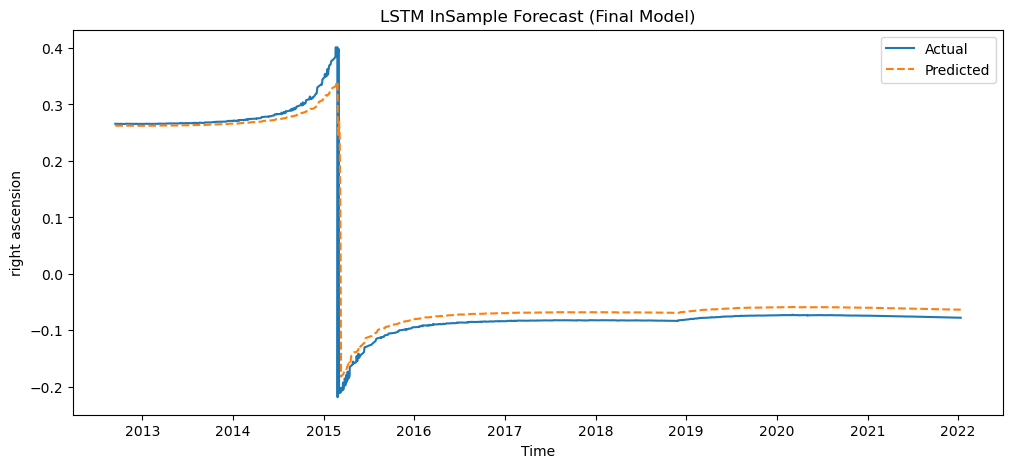

In [60]:
# Plot Actual vs. Predicted
plt.figure(figsize=(12,5))
plt.plot(idx_all, y_true, label="Actual")
plt.plot(idx_all, y_pred, linestyle="--", label="Predicted")
plt.xlabel("Time")
plt.ylabel("right ascension")
plt.title("LSTM InSample Forecast (Final Model)")
plt.legend()
plt.show()

### Anomaly Detection via Quantile Thresholds

Lower threshold (1%): -0.019966243897299424 Upper threshold (99%): 0.04674726381314227


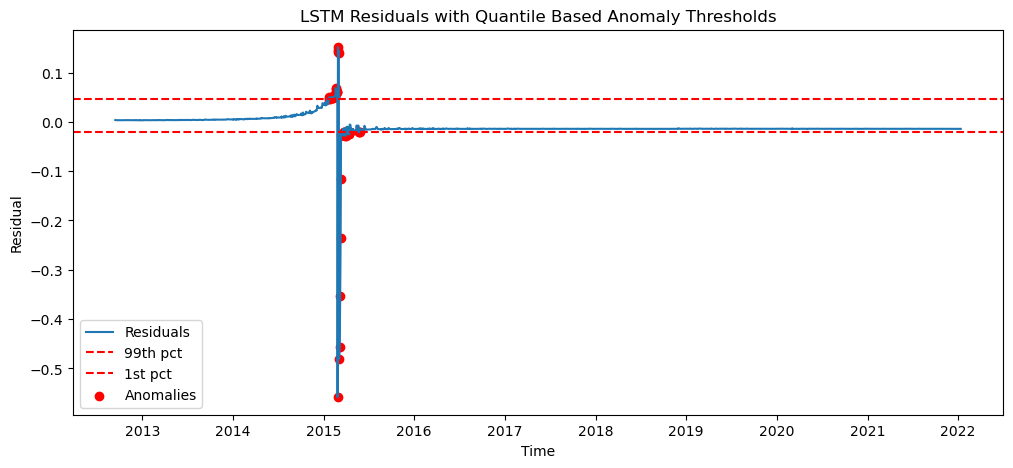

In [61]:
lower = np.quantile(residuals, 0.01)
upper = np.quantile(residuals, 0.99)
print("Lower threshold (1%):", lower, "Upper threshold (99%):", upper)

mask = (residuals < lower) | (residuals > upper)
anomaly_idx = idx_all[mask]
anomaly_vals = residuals[mask]

plt.figure(figsize=(12,5))
plt.plot(idx_all, residuals, label="Residuals")
plt.axhline(upper, color='red', linestyle="--", label="99th pct")
plt.axhline(lower, color='red', linestyle="--", label="1st pct")
plt.scatter(anomaly_idx, anomaly_vals, color='red', label="Anomalies")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.title("LSTM Residuals with Quantile Based Anomaly Thresholds")
plt.legend()
plt.show()

In [62]:
anomaly_idx

DatetimeIndex(['2015-01-21 13:01:15.989088', '2015-01-23 22:14:48.244992',
               '2015-01-25 00:17:58.559711', '2015-01-26 11:04:54.471648',
               '2015-01-30 21:19:35.393376', '2015-01-31 21:32:04.141823',
               '2015-02-02 02:26:57.476832', '2015-02-03 20:47:07.888128',
               '2015-02-04 21:12:59.622624', '2015-02-05 23:09:38.443392',
               '2015-02-07 11:49:23.066112', '2015-02-08 20:49:12.756864',
               '2015-02-09 21:31:04.091231', '2015-02-11 12:08:45.873600',
               '2015-02-12 14:13:19.445087', '2015-02-13 18:40:31.352160',
               '2015-02-14 21:07:08.015231', '2015-02-16 10:57:41.874623',
               '2015-02-17 20:31:58.345824', '2015-02-18 06:51:05.808095',
               '2015-02-19 06:47:59.275680', '2015-02-20 15:47:03.845759',
               '2015-02-21 17:05:06.591840', '2015-02-22 20:32:13.147007',
               '2015-02-24 03:37:58.289375', '2015-02-25 19:58:37.003872',
               '2015-02-2

In [63]:
len(anomaly_idx)

60

| Satellite     | Orbital Element       | ARIMA    | XGBoost  | LSTM     |
|---------------|------------------------|----------|----------|----------|
| CryoSat-2     | Brouwer mean motion    | 0.048125 | 0.064142 | <span style="color:red">0.322491</span> |
| CryoSat-2     | Inclination            | 0.026382 | <span style="color:red">0.018524</span> | 0.074272 |
| Fengyun-2F    | Eccentricity           | 0.016900 | <span style="color:red">0.008521</span> | 0.010506 |
| Fengyun-2F    | Right Ascension        | <span style="color:red">0.001161</span> | 0.001719 | 0.014179 |
| Jason-1       | Brouwer mean motion    | <span style="color:red">0.002905</span> | 0.006377 | 0.008234 |
| Jason-1       | Eccentricity           | 0.046415 | <span style="color:red">0.034372</span> | 0.061472 |
| Sentinel-3A   | Brouwer mean motion    | 0.138014 | <span style="color:red">0.104188</span> | 0.136306 |
| Sentinel-3A   | Eccentricity           | 0.015395 | <span style="color:red">0.004307</span> | 0.016871 |
